In [1]:
import tensorflow.keras.backend as K
import tensorflow as tf
import cv2 as cv
import numpy as np
import utils.model_helper as mh
import utils.data_utils as du
import utils.metrics as M
import os
import matplotlib.pyplot as plt
from PIL import Image

2023-06-11 00:30:05.655276: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-11 00:30:05.687695: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-11 00:30:05.688254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 00:30:06.473411: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.__version__

'2.12.0'

In [3]:
DATASET_PATH = '/home/irizqy/ml_ws/bangkit-ws/data/bizz.it-sim_dataset'

In [4]:
(train_pairs, train_labels), (test_pairs, test_labels) = du.make_train_test_pairs(DATASET_PATH, .2, use_gray=True)
train_pairs.shape, train_labels.shape, test_pairs.shape, test_labels.shape

((562, 2, 150, 150), (562,), (140, 2, 150, 150), (140,))

In [5]:
np.unique(train_labels, return_counts=True), np.unique(test_labels, return_counts=True)

((array([0, 1]), array([267, 295])), (array([0, 1]), array([84, 56])))

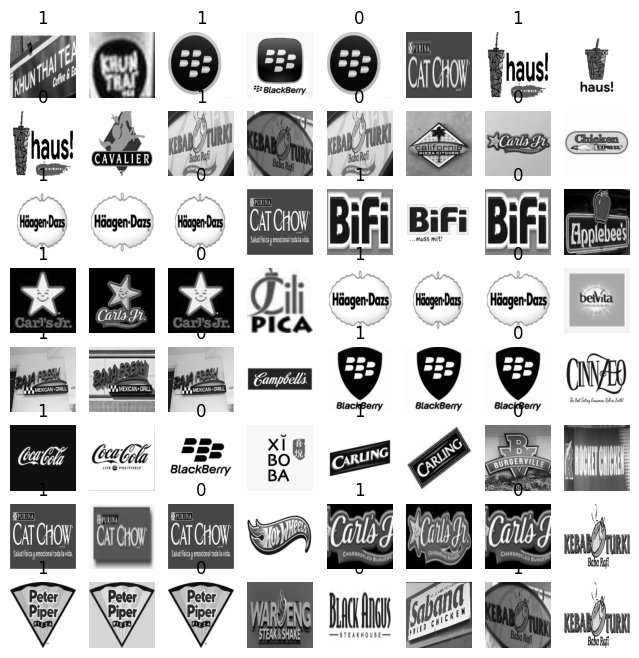

In [6]:
w = 20
h = 15
fig = plt.figure(figsize=(8, 8))
columns = 8
rows = 8
for index, i in enumerate(range(1, (columns*rows +1)//2 + 1)):
    img = train_pairs[index][0]
    fig.add_subplot(rows, columns, 2*i - 1) 
    plt.title(train_labels[index])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    img = train_pairs[index][1]
    fig.add_subplot(rows, columns, 2*i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')


In [7]:
IMG_SHAPE = (150, 150, 1)
BATCH_SIZE = 8
EPOCHS = 50

In [8]:
train_step = train_pairs.shape[0] // BATCH_SIZE
test_step = test_pairs.shape[0] // BATCH_SIZE

print(train_step, test_step)

70 17


In [9]:
class SiameseModel:

    def __init__(self, input_shape, embedding_dim=224):
        self.input_shape = input_shape
        self.embedding_dim = embedding_dim

    def _build(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=self.input_shape),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(32, (10, 10), activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(64, (7, 7), activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            # tf.keras.layers.Conv2D(128, (4, 4), activation='relu'),
            # tf.keras.layers.MaxPooling2D(),

            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(self.embedding_dim),
            tf.keras.layers.Dropout(.2),
        ])

        return model

In [10]:
sm = SiameseModel(IMG_SHAPE)

featureExtractor = sm._build()

# base_cnn =  tf.keras.applications.resnet.ResNet50(
#     weights='imagenet', input_shape=IMG_SHAPE, include_top=False
# )

# cnn_model = base_cnn.get_layer('conv5_block3_2_conv')

# flatten = tf.keras.layers.Flatten()(cnn_model.output)
# dense_2 = tf.keras.layers.Dense(units=224)(flatten)

# featureExtractor = tf.keras.Model(base_cnn.input, dense_2)

# for layer in featureExtractor.layers[:-35]:
#     layer.trainable = False

featureExtractor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 65, 65, 32)        51232     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        100416    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 64)       0

2023-06-11 00:30:12.392424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-11 00:30:12.392825: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
# configure the siamese network
print("[INFO] building siamese network...")
imgA = tf.keras.layers.Input(shape=IMG_SHAPE)
imgB = tf.keras.layers.Input(shape=IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

[INFO] building siamese network...


In [12]:
# finally, construct the siamese network
distance = tf.keras.layers.Lambda(M.euclidean_distance)([featsA, featsB])
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(distance)
model = tf.keras.Model(inputs=[imgA, imgB], outputs=outputs)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224)          203296      ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [14]:
tb = tf.keras.callbacks.TensorBoard(log_dir='./log/', histogram_freq=0,  
          write_graph=True, write_images=True)

In [15]:
tf.keras.backend.clear_session()
# compile the model
print("[INFO] compiling model...")
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(),
	metrics=["accuracy"])
# train the model
print("[INFO] training model...")
history = model.fit(
	[train_pairs[:, 0], train_pairs[:, 1]], train_labels[:],
	validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_labels[:]),
	batch_size=BATCH_SIZE,
    callbacks=[tb],
	# steps_per_epoch=train_step,
    # validation_steps=test_step,
	epochs=EPOCHS) 

[INFO] compiling model...
[INFO] training model...
Epoch 1/50
71/71 [==============================] - 17s 220ms/step - loss: 0.6963 - accuracy: 0.4733 - val_loss: 0.6949 - val_accuracy: 0.4000
Epoch 2/50
71/71 [==============================] - 16s 232ms/step - loss: 0.6940 - accuracy: 0.4698 - val_loss: 0.6962 - val_accuracy: 0.4000
Epoch 3/50
71/71 [==============================] - 15s 209ms/step - loss: 0.6934 - accuracy: 0.4733 - val_loss: 0.6977 - val_accuracy: 0.4000
Epoch 4/50
56/71 [======================>.......] - ETA: 3s - loss: 0.6933 - accuracy: 0.5201

In [ ]:
def plot_training(H):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")

In [ ]:
plot_training(history)

In [ ]:
model.save('/home/irizqy/ml_ws/bangkit-ws/src/logo-detector/im_similar')

In [ ]:
model = tf.keras.models.load_model('/home/irizqy/ml_ws/bangkit-ws/src/logo-detector/im_similar')

In [ ]:
preds = []

BASE_TEST_PATH = '/home/irizqy/Downloads/franchise'
test_data = os.listdir(BASE_TEST_PATH)

path_im1_1 = '/home/irizqy/ml_ws/bangkit-ws/src/logo-detector/cropped-logo0.jpg'
path_im1_2 = '/home/irizqy/Downloads/franchise/ct.jpg'

path_im2_1 = '/home/irizqy/ml_ws/bangkit-ws/data/bizz.it-sim_dataset/sabana_12.jpg'
path_im2_2 = '/home/irizqy/Downloads/jj_5.png'

im1 = mh.adjust_im(path_im2_2, (150, 150), use_gray=True)
# im2 = mh.adjust_im(path_im2_2, (150, 150))

# model.predict((im1, im2))[0][0]

for file in test_data:
    im2 = mh.adjust_im(os.path.join(BASE_TEST_PATH, file), (150, 150), use_gray=False)
    pred = model.predict((im1, im2))[0][0]
    preds.append(pred)

preds = np.asarray(preds)

In [ ]:
max_idx = np.argmax(preds)
print(max_idx, preds[max_idx])

In [ ]:
{key: val.split('.')[0] for key, val in enumerate(test_data)}

In [ ]:
preds

In [ ]:
test_data[max_idx]